In [1]:
%load_ext autoreload
%autoreload 1

import segmentation_models_pytorch as smp
from PIL import Image
import os
from pathlib import Path
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T

%aimport DataScienceBowl
from DataScienceBowl import DataScienceBowl
%aimport Trainer
from Trainer import Trainer

In [2]:
# Set device to GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('using cuda')
else:
    torch.device('cpu')
    print('using cpu')
    
# Set seeds
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

using cuda


In [3]:
# Load UNet Model
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [4]:
# Define Transforms
# TODO Separate Train and Test transforms
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
#     T.ToTensor()
#     T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [26]:
# Load data and split into train and test
dataset = DataScienceBowl('data/data_science_train', transform=transform)

indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-50])
validation_dataset = torch.utils.data.Subset(dataset, indices[-100:])

# train_dataset = torch.utils.data.Subset(dataset, indices[:50])
# validation_dataset = torch.utils.data.Subset(dataset, indices[-60:-10])
test_dataset = torch.utils.data.Subset(dataset, indices[-50:])


dataLoader_training = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
dataLoader_validation = DataLoader(dataset=validation_dataset, batch_size=8, shuffle=True)
dataLoader_test = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

In [ ]:
# Use Binary Cross Entropy Loss and Stochastic Gradient Descent
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

trainer = Trainer(model=model,
                 device=device,
                 criterion=criterion,
                 optimizer=optimizer,
                 training_DataLoader=dataLoader_training,
                 validation_DataLoader=dataLoader_validation,
                 test_DataLoader=dataLoader_test,
                 epochs=15,
                 notebook=True)

train_loss, val_loss, lr, test_loss, test_iou = trainer.run_trainer()



Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/78 [00:00<?, ?it/s]

In [19]:
# torch.save(model.state_dict(), 'UNet_pretrained.pt')

In [7]:
print(test_loss, test_iou)

0.3830778405070305 0.030625548329047986


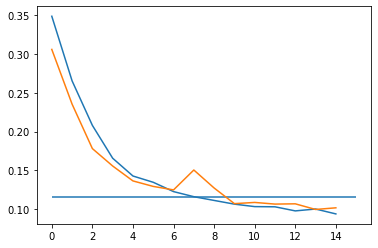

In [14]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.hlines(test_loss, 0, 15)
plt.show()

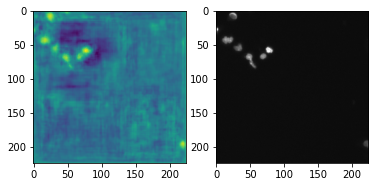

In [15]:
sample = train_dataset[0]
img, target = sample.values()
model.eval()
out = model(img.unsqueeze(0).to(device))

# print(out)

f,a = plt.subplots(1,2)

a[0].imshow(out.squeeze(0).permute(1,2,0).detach().cpu().numpy())
a[1].imshow(img.permute(1,2,0)/255)
plt.show()


C:\Users\Harm\.conda\envs\thesis\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


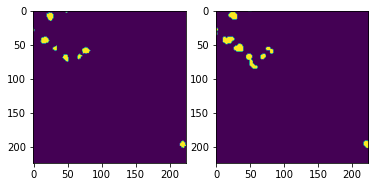

In [16]:
import torch.nn.functional as F

mask = F.sigmoid(out) > 0.5

mask = mask.squeeze(0).squeeze(0).detach().cpu().numpy()

target = target.squeeze(0).type(torch.BoolTensor).detach().numpy()

f, a = plt.subplots(1,2)

a[0].imshow(mask)
a[1].imshow(target)

# plt.imshow(mask)
plt.show()

In [17]:
# IoU
from sklearn.metrics import jaccard_score

print(np.unique(mask.astype('int')))
print(np.unique(target.astype('int')))
# print(np.unique(target))

jaccard_score(mask.reshape(-1), target.reshape(-1))

[0 1]
[0 1]


0.4957780458383595

In [18]:
test_iou

0.6653905689472833